In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
from tqdm import tqdm
import timeit

Input data:  
- CCLE_expression.csv  
Gene expression TPM (transcript per million) values of the protein coding genes for DepMap cell lines  
log2(TPM+1) goes from 0.00 to 17.78


- CRISPR_gene_effect.csv
Gene effect of the protein coding genes for DepMap cell lines
Gene Effect scores derived from CRISPR knockout screens published by Broad’s Achilles and Sanger’s SCORE projects.  
Negative scores imply cell growth inhibition and/or death following gene knockout. Scores are normalized such that nonessential genes have a median score of 0 and independently identified common essentials have a median score of -1.
SCORE goes from -3.89 to 2.73. 

- preprocess/index_to_protein_and_gene.txt

- preprocess/adjacence_matrix.txt

Genes:16,481  
Cell Lines:1,081  
Primary Diseases:31 (?)  
Lineages:28 (?)

## Retrieve data 

In [5]:
gene_expression = pd.read_csv('preprocess/gene_expression.csv').set_index('DepMap')
gene_effect = pd.read_csv('preprocess/gene_effect.csv').set_index('DepMap')

In [19]:
protein_info = pd.read_csv('preprocess/index_to_protein_and_gene.txt', header=None, sep=' ')
protein_info = protein_info.rename(columns={0:'index', 1:'protein', 2:'gene_ID'})
protein_info = protein_info.set_index('index')

In [35]:
adjacence_matrix = np.loadtxt('preprocess/adjacence_matrix.txt', delimiter=' ', dtype=int)

In [27]:
gene_expression.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,3.116032,0.056584,0.226509,0.111031,0.000000,1.035624,0.176323,5.700440,4.144046,0.790772,...,5.080658,6.675957,0.978196,1.914565,4.700994,3.282440,2.797013,6.821455,3.010780,4.381975
ACH-000002,1.395063,0.000000,0.275007,0.111031,0.000000,0.137504,0.000000,5.078951,1.948601,0.000000,...,3.204767,6.388017,0.097611,1.000000,3.925050,0.000000,1.070389,5.963474,2.169925,3.255501
ACH-000003,1.400538,4.305241,0.321928,0.150560,0.000000,4.219556,0.097611,5.195348,3.962549,1.687061,...,4.013462,7.528181,0.464668,1.555816,2.851999,0.704872,2.316146,7.302867,2.659925,2.748461
ACH-000004,4.178715,0.000000,0.214125,0.344828,0.070389,0.097611,0.000000,6.336819,3.231125,0.000000,...,4.276497,6.098664,0.765535,1.622930,3.619413,0.014355,2.032101,7.002252,3.444932,4.910733
ACH-000005,4.003602,0.014355,0.137504,0.014355,0.000000,0.028569,0.000000,6.337176,3.781360,0.000000,...,5.628482,6.785289,0.807355,1.773996,3.763412,0.014355,2.761285,6.826421,3.524816,5.592457


In [28]:
gene_effect.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
DepMap,,,,,,,,,,,,,,,,,,,,,
ACH-000001,-0.134808,0.059764,-0.008665,-0.003572,-0.106211,-0.008257,0.018711,-0.291985,0.010921,0.064932,...,-0.037619,-0.116524,-0.029331,0.105940,0.147605,-0.119822,0.063387,0.160857,0.058648,-0.316792
ACH-000004,0.081853,-0.056401,-0.106738,-0.014499,0.078209,-0.137562,0.168657,-0.198560,0.133372,0.151300,...,-0.030901,-0.262220,0.136406,0.031327,0.093763,-0.079692,-0.173709,0.153632,0.175627,-0.040869
ACH-000005,-0.094196,-0.014598,0.100426,0.169103,0.032363,-0.148050,0.168931,-0.244777,-0.086871,-0.036037,...,0.039434,-0.336925,-0.095528,-0.035541,-0.035612,-0.040183,-0.165464,0.077343,0.019387,-0.085687
ACH-000007,-0.011544,-0.123189,0.080692,0.061046,-0.013454,-0.016922,-0.029474,-0.206516,-0.063998,0.139288,...,-0.229303,-0.463191,0.061641,0.190301,0.119388,-0.036695,-0.182449,-0.146936,-0.189451,-0.281167
ACH-000009,-0.050782,-0.037466,0.068885,0.090375,0.012634,-0.079339,-0.017808,-0.183192,0.006227,-0.001700,...,-0.157219,-0.318765,0.015761,0.196949,-0.045874,-0.186805,-0.275629,-0.001227,-0.049140,-0.240582


In [26]:
protein_info.head()

,protein,gene_ID
index,,
0,9606.ENSP00000263100,A1BG
1,9606.ENSP00000378868,A1CF
2,9606.ENSP00000323929,A2M
3,9606.ENSP00000299698,A2ML1
4,9606.ENSP00000475261,A3GALT2


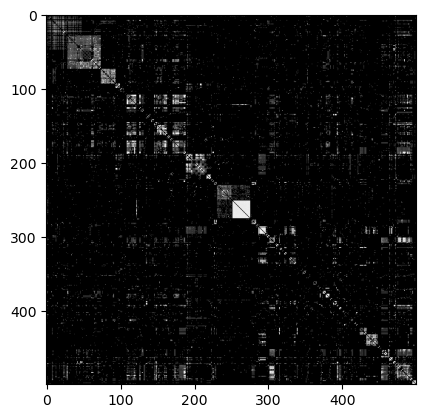

In [34]:
plt.imshow(adjacence_matrix[:500,:500], cmap='gray');plt.show()

## Smooth graph

In [89]:
def smoothen(x, lamb, adjacence_matrix):
    new_x = x * 0
    for i in range(len(x)):  # rmk: can be written as a matrix product
        alphas = adjacence_matrix[i]
        new_x[i] = lamb * x[i] + (1-lamb) * alphas.dot(cl_expression) / np.sum(alphas)
    return new_x

### Compare lambda coefficient

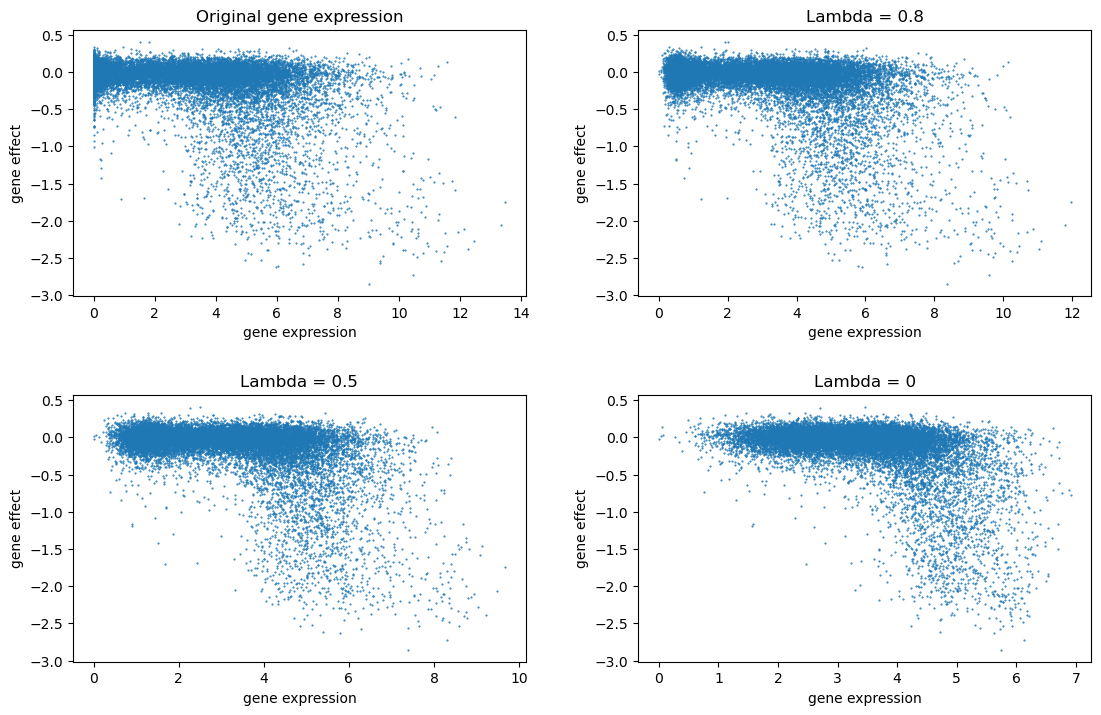

CPU times: user 32.1 s, sys: 528 ms, total: 32.7 s
Wall time: 18.1 s


In [90]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 2,2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()
axs[0].scatter(gene_expression.iloc[cell_line], 
               gene_effect.iloc[cell_line], 
               marker='.', s=1)
axs[0].set_title('Original gene expression')

lambs = [0.8, 0.5, 0]
cell_lines = [0]

for lamb_idx, lamb in enumerate(lambs):
    xx_expression = []
    yy_effect = []
    for cell_line in cell_lines:
        cl_expression = gene_expression.iloc[cell_line]
        new_cl_expression = smoothen(cl_expression, lamb, adjacence_matrix)
        
        xx_expression.append(new_cl_expression)
        yy_effect.append(gene_effect.iloc[cell_line])
    
    xx = np.concatenate(xx_expression)
    yy = np.concatenate(yy_effect)

    axs[lamb_idx+1].scatter(xx, yy, marker='.', s=1)
    axs[lamb_idx+1].set_title(f"Lambda = {lamb}")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

#for ax in axs.flat:
#    ax.label_outer()   

plt.show()

### Compare multiple smoothing

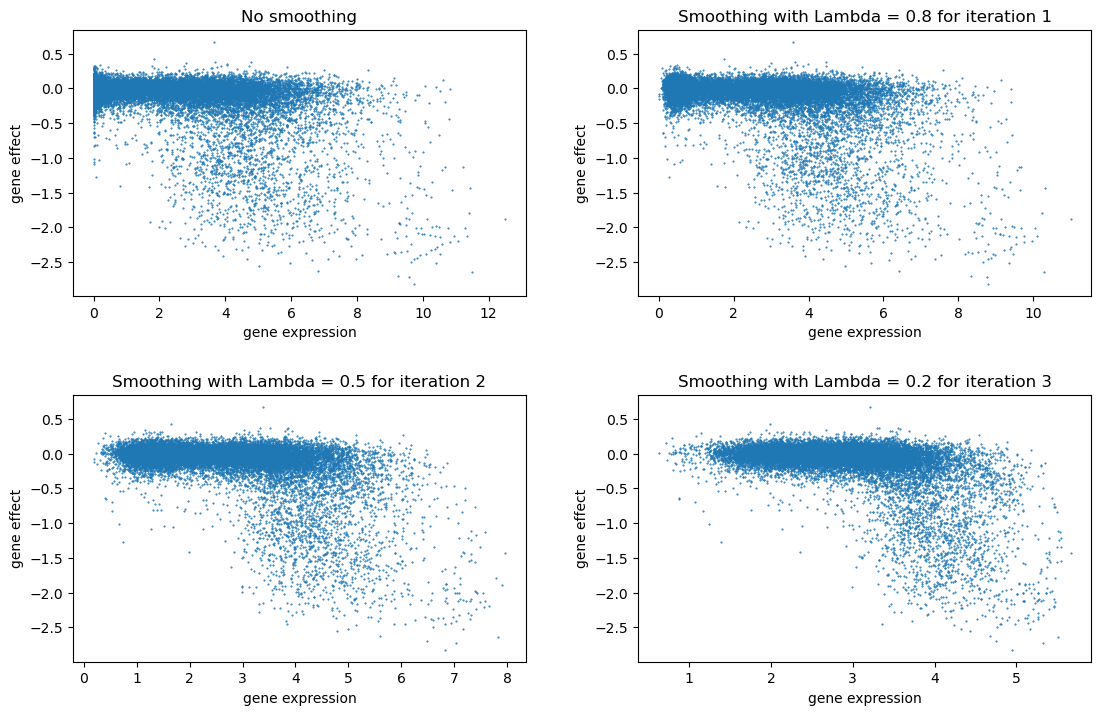

CPU times: user 21.8 s, sys: 2.44 s, total: 24.2 s
Wall time: 16.2 s


In [97]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 2, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

#lambs = [0.5] * 3
lambs = [0.8, 0.5, 0.2]
cell_line = 253
cl_expression = gene_expression.iloc[cell_line]
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title('No smoothing')

for smoothing_idx in range(3):
    lamb = lambs[smoothing_idx]
    cl_expression = smoothen(cl_expression, lamb, adjacence_matrix)

    axs[smoothing_idx+1].scatter(cl_expression, 
                            gene_effect.iloc[cell_line], 
                            marker='.', s=1)
    #axs[smoothing_idx+1].set_title(f"Smoothing {smoothing_idx+1} times")
    axs[smoothing_idx+1].set_title(f"Smoothing with Lambda = {lamb} for iteration {smoothing_idx+1}")
    

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

### Other types of layer

In [103]:
def graphnn_layer(x, adjacence_matrix, params, aggr='sum', normalize=True, bias=None):
    new_x = x * 0
    
    if (type(params) is list or type(params) is tuple) and len(params) > 1:
        pass
    else:
        params = [params, 1 - params]
        
    for i in range(len(x)):  # rmk: can be written as a matrix product
        alphas = adjacence_matrix[i]
        norm_factor = np.sum(alphas) if normalize else 1
        if aggr == 'add':
            new_x[i] = params[0] * x[i] + params[1] * np.sum(alphas * cl_expression) / norm_factor
        elif aggr == 'mean':
            nb_neighbors = np.sum(alphas > 0)
            new_x[i] = params[0] * x[i] + params[1] * np.sum(alphas * cl_expression) / (norm_factor * nb_neighbors)
        elif aggr == 'max':
            new_x[i] = params[0] * x[i] + params[1] * np.max(alphas * cl_expression) / (norm_factor)
    
    if bias is not None:
        new_x += bias
        
    return new_x

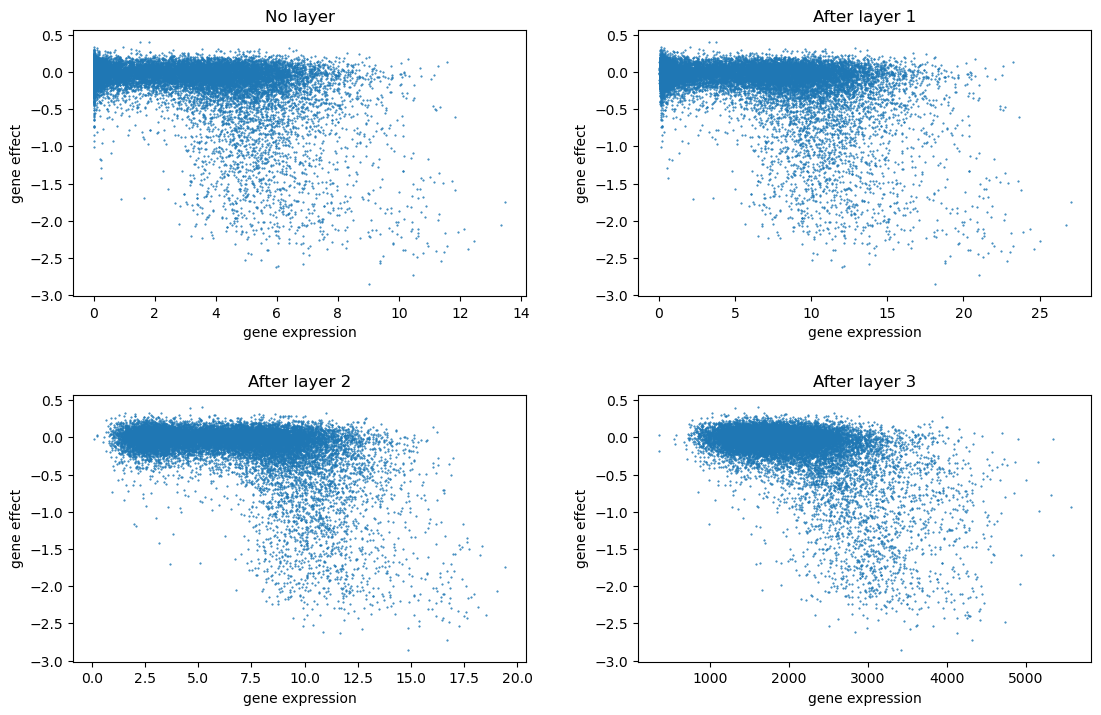

CPU times: user 26.2 s, sys: 977 ms, total: 27.1 s
Wall time: 27.5 s


In [107]:
%%time
fig_width = 6
fig_height = 4
nb_i, nb_j = 2, 2

fig, axs = plt.subplots(nb_i, nb_j, figsize=(nb_j*fig_width, nb_i*fig_height))
fig.tight_layout(pad=5.0)
axs = axs.flatten()

layers = [
    {'params':0.5, 'aggr':'add'},
    {'params':[1, 0.2], 'aggr':'max'},
    {'params':[0.9, 0.1], 'aggr':'mean', 'normalize':False, 'bias':0.1}
]
layers = [
    {'params':[1,2], 'aggr':'max'},
    {'params':0.5, 'aggr':'add'},
    {'params':[3, 1], 'aggr':'mean', 'normalize':False, 'bias':-2}
]
cell_line = 0
cl_expression = gene_expression.iloc[cell_line]
axs[0].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
axs[0].set_title('No layer')

for i,layer in enumerate(layers):
    lamb = lambs[smoothing_idx]
    cl_expression = graphnn_layer(cl_expression, adjacence_matrix, **layer)

    axs[i+1].scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
    axs[i+1].set_title(f"After layer {i+1}")

for ax in axs.flat:
    ax.set(xlabel='gene expression', ylabel='gene effect')

plt.show()

In [63]:
np.concatenate([np.random.random(4),np.random.random(4),np.random.random(4)])

array([0.18261912, 0.43280708, 0.36163595, 0.15622244, 0.88147223,
       0.45211207, 0.17781616, 0.5144423 , 0.90104453, 0.16525434,
       0.293115  , 0.39455428])

In [54]:
cl_expression

A1BG       3.116032
A1CF       0.056584
A2M        0.226509
A2ML1      0.111031
A3GALT2    0.000000
             ...   
ZYG11A     3.282440
ZYG11B     2.797013
ZYX        6.821455
ZZEF1      3.010780
ZZZ3       4.381975
Name: ACH-000001, Length: 16481, dtype: float64

In [55]:
new_cl_expression

A1BG       2.694897
A1CF       1.469358
A2M        1.347078
A2ML1      1.345658
A3GALT2    1.414557
             ...   
ZYG11A     3.516820
ZYG11B     3.327356
ZYX        5.601573
ZZEF1      3.298114
ZZZ3       4.438717
Name: ACH-000001, Length: 16481, dtype: float64

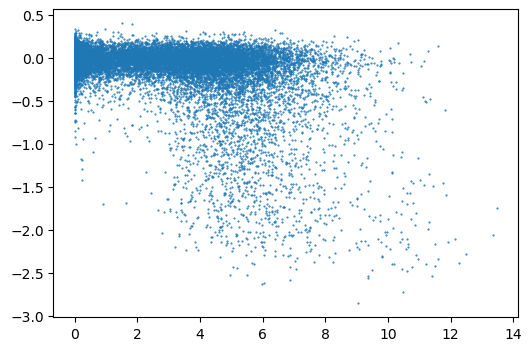

In [61]:
fig = plt.figure(figsize=(6,4))
plt.scatter(cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
plt.show()

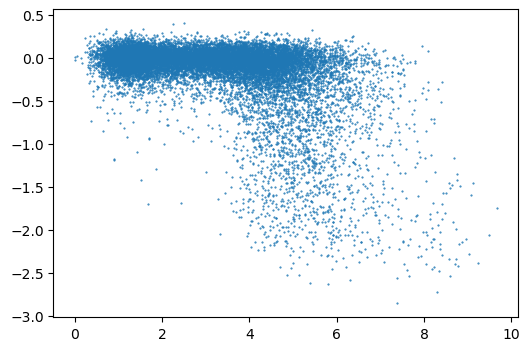

In [60]:
fig = plt.figure(figsize=(6,4))
plt.scatter(new_cl_expression, gene_effect.iloc[cell_line], marker='.', s=1)
plt.show()